In this notebook, we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  http://invibe.net/LaurentPerrinet/Publications/Perrinet10shl ). Compared to the [previous post](http://blog.invibe.net/posts/2017-03-29-testing-comps-fastpcum.html), we integrated the faster code to https://github.com/bicv/SHL_scripts.

See also the other posts on [unsupervised learning](http://blog.invibe.net/categories/learning.html),

This is joint work with [Victor Boutin](http://invibe.net/LaurentPerrinet/VictorBoutin).

<!-- TEASER_END -->

Summary: using the functions from the module allows to achieve homeostasis in the coding.

# using fast Pcum functions from shl_scripts

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
np.set_printoptions(formatter = dict( float = lambda x: "%.3g" % x ), precision=3, suppress=True, threshold=np.inf)
import time


In [2]:
matname = '2017-05-31_Testing_COMPs'
DEBUG_DOWNSCALE = 1
#matname = '2017-05-31_Testing_COMPs-DEBUG'
#DEBUG_DOWNSCALE = 10

seed = 42
nb_quant = 256
C = 4.
do_sym = False

from shl_scripts.shl_experiments import SHL
shl = SHL(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
           eta=0.05, verbose=2, record_each=50, n_iter=1000, eta_homeo=0., alpha_homeo=1., 
          do_sym=do_sym, nb_quant=nb_quant, C=C)
data = shl.get_data(seed=seed, matname=matname)

loading the data called : /Users/laurentperrinet/tmp/data_cache/2017-05-31_Testing_COMPs_data


In [3]:
test_size = data.shape[0]//2
data_training = data[:test_size, :]
data_test = data[test_size:,:]   
#DEBUG
test_size = data.shape[0]//20
data_training = data[:(data.shape[0]-test_size),:].copy()
data_test = data[:test_size, :].copy()

We start off by using a short learning with no homeostasis such that we end up with a unbalanced dictionary:

In [4]:
dico_partial_learning = shl.learn_dico(data=data_training, matname=matname)

loading the dico called : 2017-05-31_Testing_COMPs


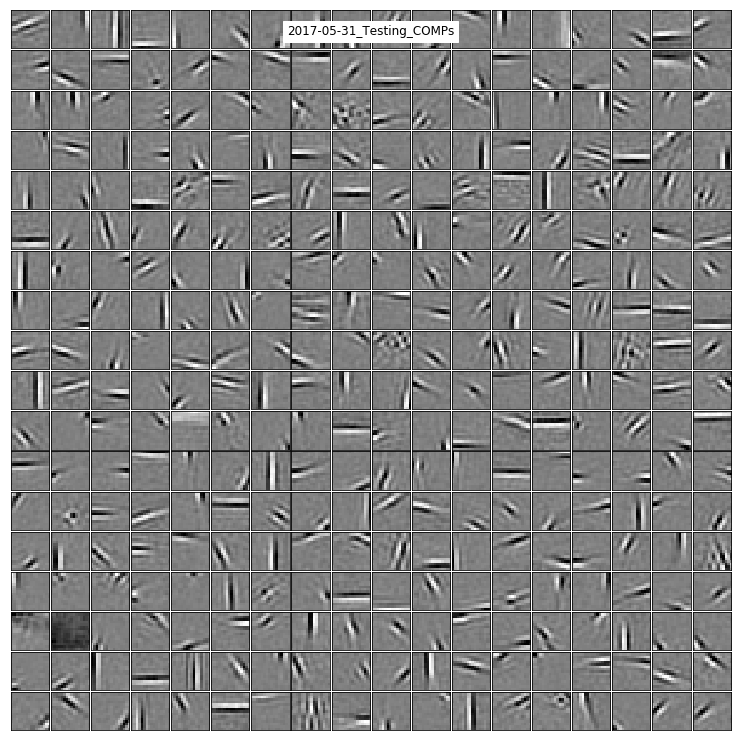

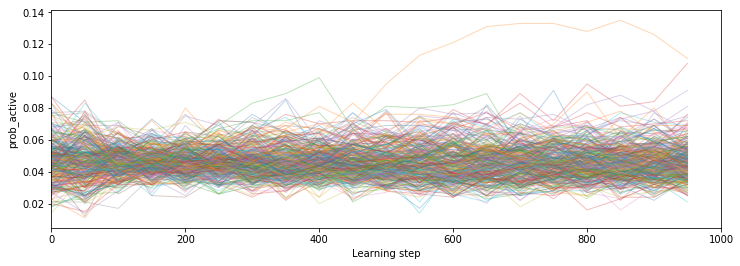

In [5]:
fig, ax = shl.show_dico(dico_partial_learning, data=data, title=matname)
fig.show()
fig, ax = shl.time_plot(dico_partial_learning, variable='prob_active');
fig.show()

## MP classique

loading the code called : /Users/laurentperrinet/tmp/data_cache/2017-05-31_Testing_COMPs_coding.npy


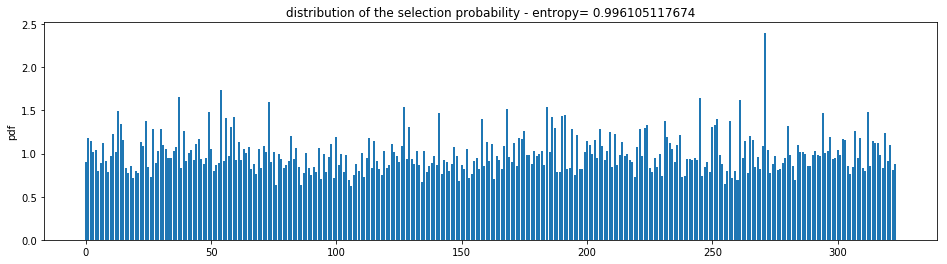

In [6]:
n_samples, n_pixels = data_test.shape
n_dictionary, n_pixels = dico_partial_learning.dictionary.shape
norm_each_filter = np.sqrt(np.sum(dico_partial_learning.dictionary**2, axis=1))
dico_partial_learning.dictionary /= norm_each_filter[:,np.newaxis]

sparse_code_mp = shl.code(data_test, dico_partial_learning, matname=matname, do_sym=do_sym)

from shl_scripts.shl_tools import plot_proba_histogram
fig, ax = plot_proba_histogram(sparse_code_mp)

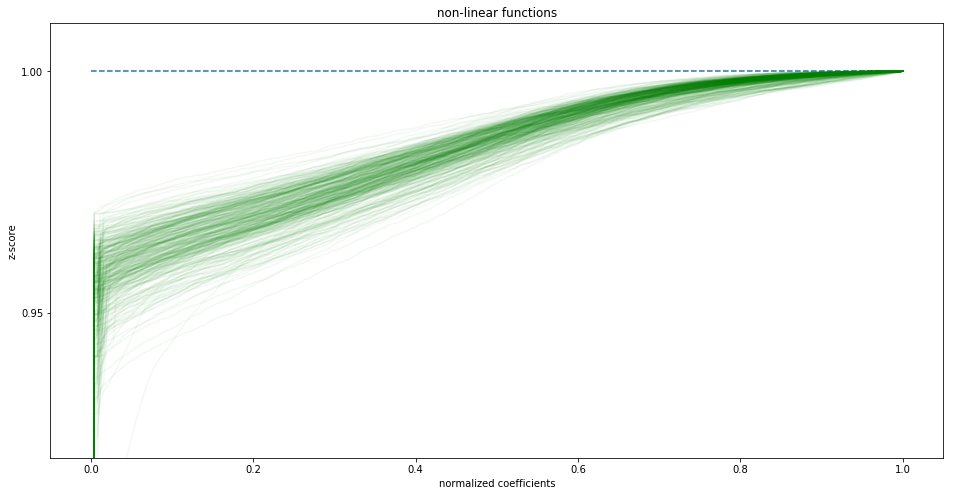

In [7]:
from shl_scripts.shl_learn import get_P_cum
P_cum_MP = get_P_cum(sparse_code_mp, nb_quant=shl.nb_quant, C=C, do_sym=do_sym)
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum_MP, verbose=False, alpha=.05)
ax.set_ylim(0.92, 1.01);

## testing that COMP with fixed Pcum  is equivalent to MP

In [8]:
n_samples, nb_filter = sparse_code_mp.shape
P_cum = np.linspace(0, 1, shl.nb_quant, endpoint=True)[np.newaxis, :] * np.ones((n_dictionary, 1))

from shl_scripts.shl_encode import mp
sparse_code_mp = mp(data_test, dico_partial_learning.dictionary, P_cum=None, verbose=1, do_sym=do_sym)
sparse_code_comp = mp(data_test, dico_partial_learning.dictionary, P_cum=P_cum, verbose=1, do_sym=do_sym, C=C)

coding duration : 13.812180995941162
coding duration : 62.96179389953613


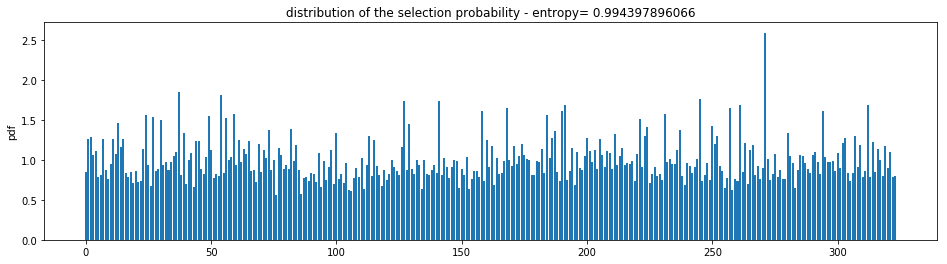

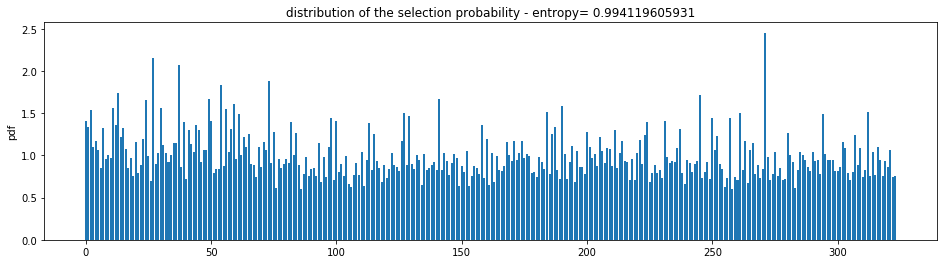

In [9]:
fig, ax = plot_proba_histogram(sparse_code_mp)
fig.show()
fig, ax = plot_proba_histogram(sparse_code_comp)

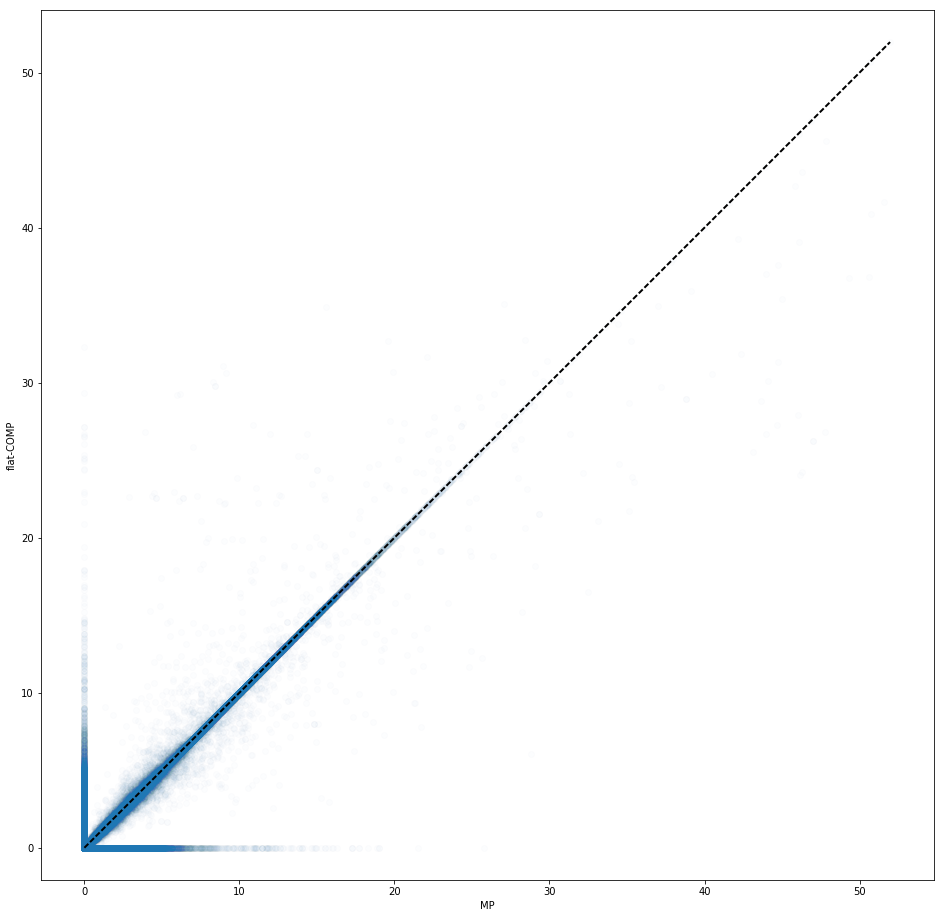

In [10]:
from shl_scripts.shl_tools import plot_scatter_MpVsTrue

fig, ax = plot_scatter_MpVsTrue(sparse_code_mp, sparse_code_comp, xlabel='MP', ylabel='flat-COMP')

## gradient descent 

Shape of modulation function (324, 256)
Learning step 0
Learning step 100
Learning step 200
Learning step 300
Learning step 400
Learning step 500
Learning step 600
Learning step 700
Learning step 800
Learning step 900


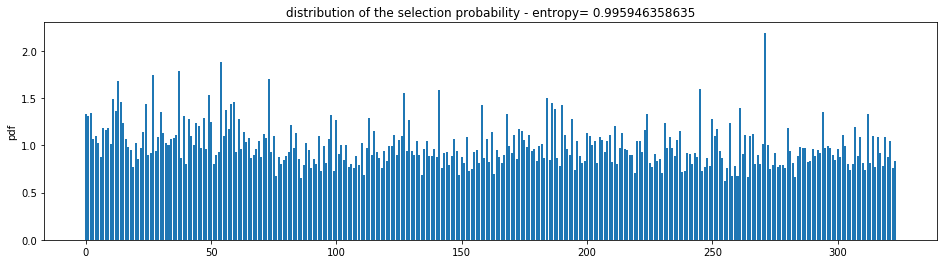

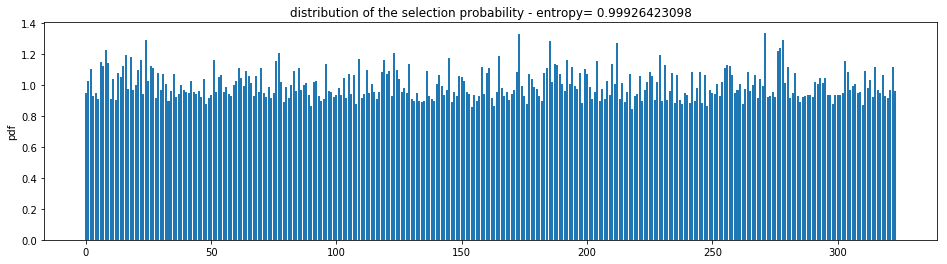

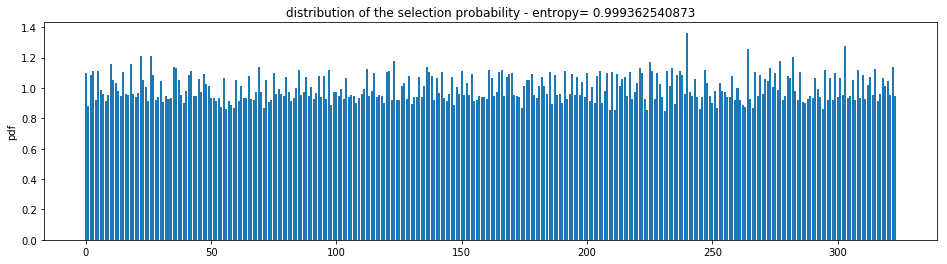

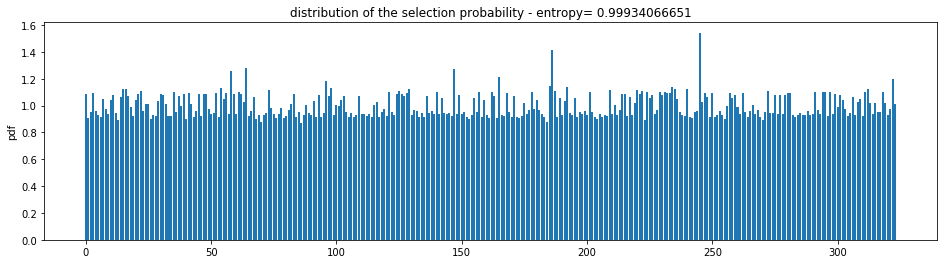

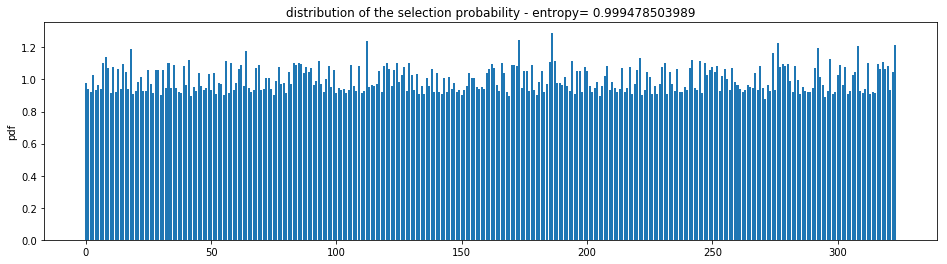

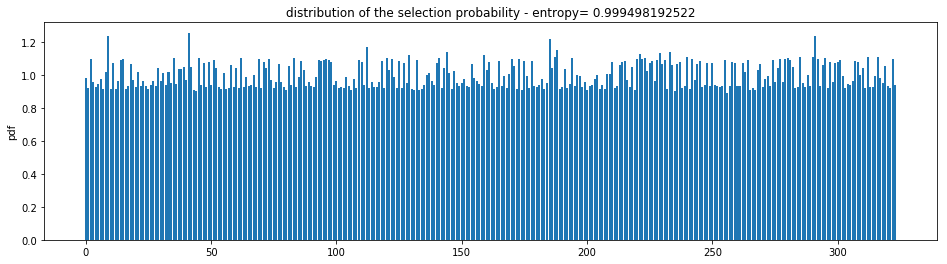

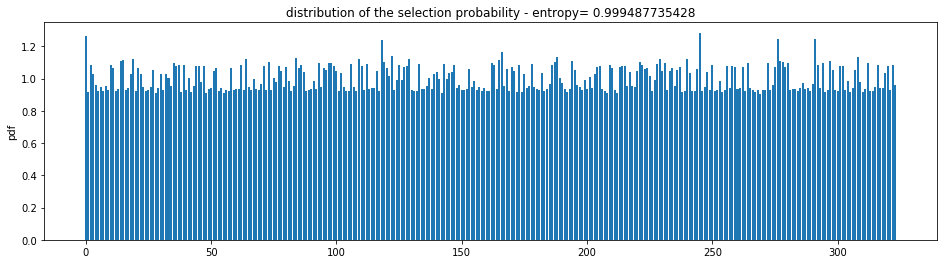

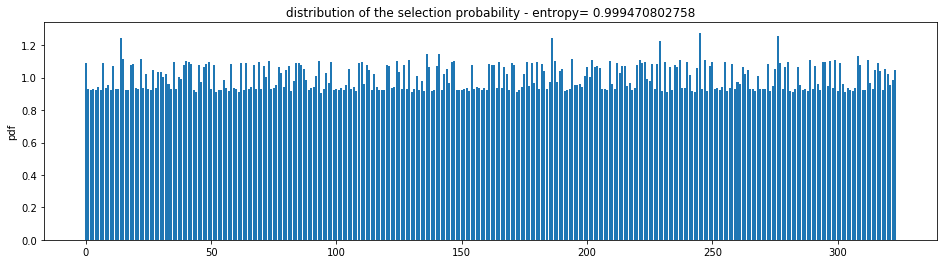

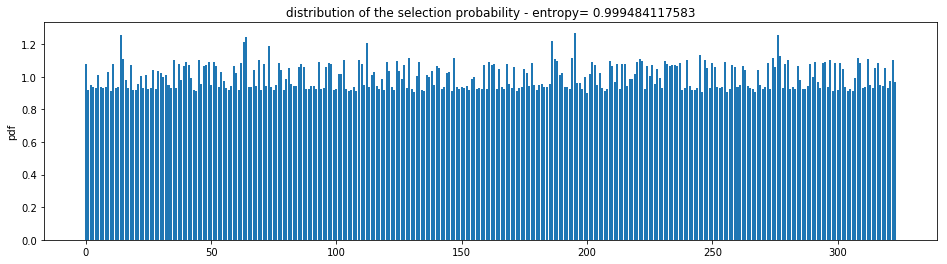

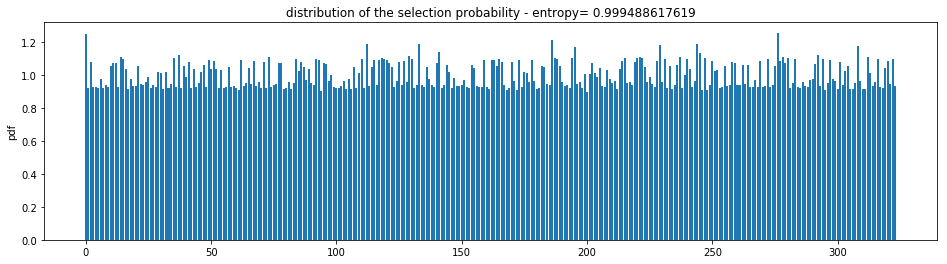

In [11]:
P_cum = np.linspace(0, 1, shl.nb_quant, endpoint=True)[np.newaxis, :] * np.ones((n_dictionary, 1))
print('Shape of modulation function', P_cum.shape)
from shl_scripts.shl_tools import plot_proba_histogram
from shl_scripts.shl_learn import update_P_cum

eta_homeo = .05
verbose = 1

for i in range(1000):
    sparse_code = mp(data_test, dico_partial_learning.dictionary, l0_sparseness=shl.l0_sparseness, P_cum=P_cum, C=C, verbose=0, do_sym=do_sym)
    P_cum = update_P_cum(P_cum, sparse_code, eta_homeo=eta_homeo, nb_quant=shl.nb_quant, verbose=verbose, do_sym=do_sym)
    if i % 100 == 0:
        print('Learning step', i)
        fig, ax = plot_proba_histogram(sparse_code)

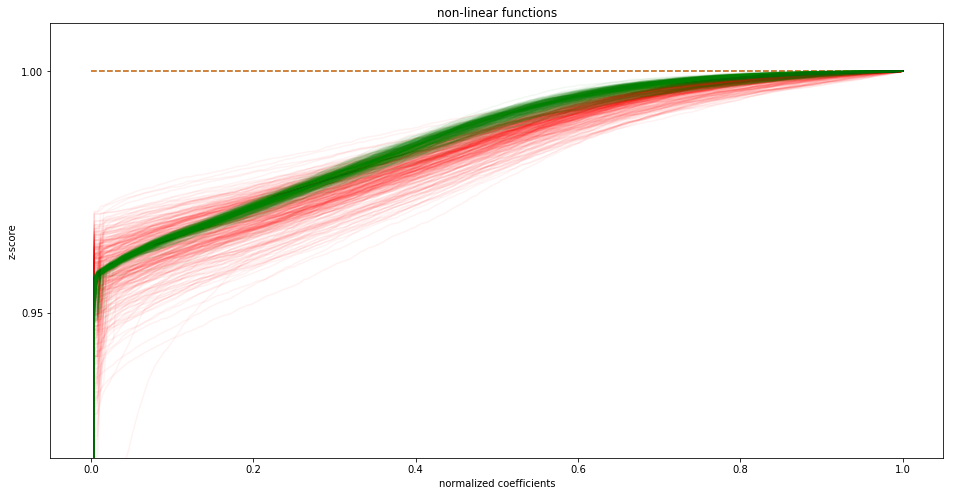

In [12]:
from shl_scripts.shl_tools import plot_P_cum

fig, ax = plot_P_cum(P_cum_MP, verbose=False, c='r');
fig, ax = plot_P_cum(P_cum, verbose=False, c='g', fig=fig, ax=ax);
ax.set_ylim(0.92, 1.01);


fig.savefig('2_D-testing_COMP.pdf')

Conclusion : we have shown how to implement  [homeostasis in the coding](http://blog.invibe.net/posts/2017-03-29-testing-comps.html) , how to [speed up things](http://blog.invibe.net/posts/2017-03-29-testing-comps-fastpcum.html) and here we integrated it to the package.